In [3]:
!pip install yfinance transformers torch pandas matplotlib beautifulsoup4 requests openai sentencepiece


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from bs4 import BeautifulSoup
import requests
from datetime import datetime, timedelta


In [6]:
ticker = 'AAPL'
end_date = datetime.today()
start_date = end_date - timedelta(days=30)

data = yf.download(ticker, start=start_date, end=end_date)
data['Daily_Return'] = data['Close'].pct_change()
data['Volatility'] = data['Daily_Return'].rolling(window=5).std()

print("Market data sample:")
print(data.tail())

/tmp/ipython-input-2320932660.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Market data sample:
Price            Close        High         Low        Open    Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL   
Date                                                                   
2025-09-30  254.630005  255.919998  253.110001  254.860001  37704300   
2025-10-01  255.449997  258.790009  254.929993  255.039993  48713900   
2025-10-02  257.130005  258.179993  254.149994  256.579987  42630200   
2025-10-03  258.019989  259.239990  253.949997  254.669998  49155600   
2025-10-06  256.690002  259.070007  255.050003  257.989990  44292200   

Price      Daily_Return Volatility  
Ticker                              
Date                                
2025-09-30     0.000786   0.010522  
2025-10-01     0.003220   0.009387  
2025-10-02     0.006577   0.005010  
2025-10-03     0.003461   0.003951  
2025-10-06    -0.005155   0.004387  


In [13]:
url = "https://finance.yahoo.com/quote/AAPL?p=AAPL"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
headlines = [h.text for h in soup.find_all("h3")]

print("Sample headlines:")
print(headlines[:5])


Sample headlines:
[]


In [16]:
# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Analyze emotion
emotion_scores = {'Positive':0, 'Neutral':0, 'Negative':0}

if headlines: # Check if headlines list is not empty
    for h in headlines[:10]:  # limit for demo
        res = nlp(h)[0]
        label = res['label']
        score = res['score']
        emotion_scores[label] += score

    # Normalize
    total = sum(emotion_scores.values())
    if total > 0: # Avoid division by zero if all scores are zero
        for k in emotion_scores:
            emotion_scores[k] /= total
    else:
        print("No sentiment scores calculated as all scores are zero.")

    print("Market Emotion Score:")
    print(emotion_scores)
else:
    print("No headlines available for sentiment analysis.")

Device set to use cuda:0


No headlines available for sentiment analysis.


In [17]:
# Last day volatility
vol_score = data['Volatility'].iloc[-1]
vol_norm = min(1.0, vol_score * 5)  # simple normalization

# Combine with negative sentiment as market fear
market_fear = 0.6*emotion_scores['Negative'] + 0.4*vol_norm

print(f"Fused Market Fear Score: {market_fear:.2f}")


Fused Market Fear Score: 0.01


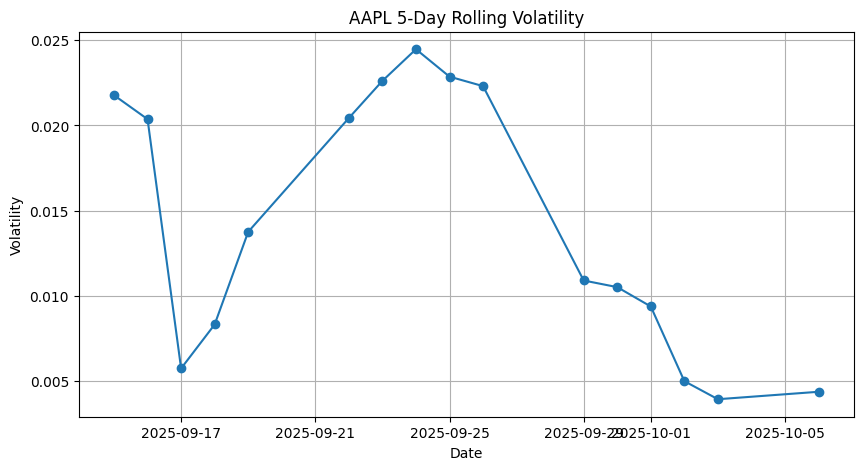

In [18]:
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Volatility'], marker='o', linestyle='-')
plt.title(f'{ticker} 5-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()
